In [25]:
#Pkg.add("NLopt")

In [2]:
using NLopt

# Example 1: Parameter Estimation

As a simple, motivating example for `RandomizeThenOptimize` (and sampling algorithms in general), we consider the problem of (Bayesian) parameter estimation. For this problem, we will set up a small algebraic model $g$ with a few unknown parameters $\theta$; and specify a few noisy measurements $y$, where 

$y_i = g(x_i,\theta) + \textrm{noise}$

Our belief on $\theta$ after seeing $y$, can be described using a distribution (the Bayesian posterior). We will use `RandomizeThenOptimize` to sample from this distribution and then visualize the samples. We will then (optionally) use `Mamba` to compute a few summary statistics.

## Setting up the problem

Consder the following model with some parameters $\theta$:

$ g(x;\theta) = \theta_1 + \theta_2 e^{\theta_3 x} $

This model is an exponential with an unknown constant: $\theta_1$, amplitude: $\theta_2$, and growth/decay rate: $\theta_3$.

In [3]:
g = (x,θ) -> θ[1] + θ[2]*exp(θ[3]*x)

(::#1) (generic function with 1 method)

Say we are given the following two noisy measurements, i.e. $(x_i,y_i)$ pairs, what can we say about $\theta$?

In [4]:
x = [-0.5; 0.5]
y = [-1; 2];

Well, two points are not enough to **uniquely** determine any of the parameters. However, if we try sampling random parameters $\theta \sim N(0,I)$ and plotting the corresponding models $g(x;\theta)$ ...

In [5]:
using Plots

In [6]:
#plotlyjs();
pyplot();


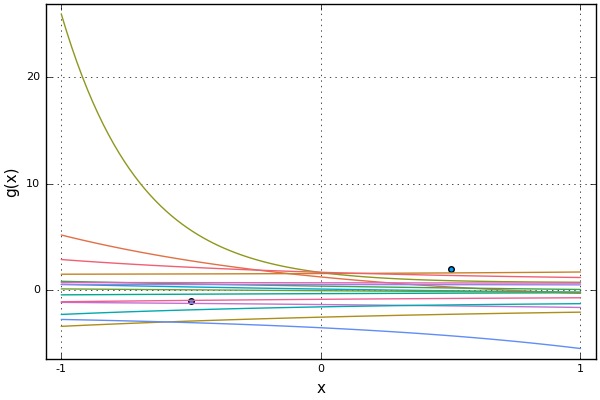

In [7]:
scatter(x,y)
for i = 1:15
    θ = randn(3)
    plot!(x -> g(x,θ), -1, 1)
end
plot!(xlabel="x", ylabel ="g(x)", legend=false)

... most of the models do not match the data closely. 

Certainly, these two data points give us **some** information about the parameters. One way we can describe this information is through a distribution. 

## Using RandomizeThenOptimize.jl
`RandomizeThenOptimize` (RTO) creates this (posterior) distribution internally and draws samples from it. 

In order to describe the problem to RTO, we need to create the forward model, $f$ -- a function that takes the parameters $\theta$ and returns the measurements (which are compared to $y$):

$ f(\theta) = \begin{bmatrix} g(x_1;\theta) \\ g(x_2;\theta) \end{bmatrix} $

Since RTO uses gradient based optimization, we also require the Jacobian matrix of the forward model $f$. The Julia `Function` we need to make should also accept an empty Jacobian matrix and fill in the entries.

In [8]:
# hand-coded gradient
dgdθ = (x,θ) -> [1; exp(θ[3]*x); θ[2]*exp(θ[3]*x)*x ]'

# note that the function takes the current point θ and an empty Jacobian matrix.
function f!(θ::AbstractVector, jac::AbstractMatrix)
    if length(jac) > 0
        # fill up the Jacobian matrix
        jac[1,:] = dgdθ(x[1],θ)
        jac[2,:] = dgdθ(x[2],θ)
    end
    
    return [g(x[1],θ); g(x[2],θ)]
end

/Users/zheng/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


f! (generic function with 1 method)

In the following few lines, we include the RTO module, and set up the problem for it.

In [9]:
include("RandomizeThenOptimize.jl")
# -- OR, you may run:
# Pkg.clone("https://github.com/wang-zheng/RandomizeThenOptimize.jl","RandomizeThenOptimize")
using RandomizeThenOptimize

The `RandomizeThenOptimize::Problem` type is a container for all the information required to solve our problem. We initialize a `Problem` by specifying the size of our parameter vector (in our case 3) and size of our data (in our case 2).

In [10]:
# initialize the problem, with 3 inputs and 2 outputs for f(θ)
p = Problem(3,2)

Problem(3,2)

We give the `Problem` all the other required information, such as forward model, data, and noise.

In [11]:
# Give p the function f!
forward_model!(p, f!);

In [12]:
verbose!(p,true);

In [13]:
# set the observational noise
obs_σ!(p,[0.3,0.3]);

In [14]:
# give p the data
obs_data!(p,y);

In [15]:
# intialize the guess
#guess!(p,[1.,-1,-1])

We call the function `rto_mcmc(p::Problem, nsamps::Integer)` to generate samples from the (posterior) distribution. It returns a chain of **correlated** samples stored in a $nsamps \times n$ matrix, where $nsamps$ is the number of samples requested and $n$ is the size of our parameter vector.

In [16]:
# sample!
chain = rto_mcmc(p,30);

Optimizing for MAP... FTOL_REACHED.
Sampling... done.
Metropolizing... done.


## Analyzing and Plotting

We can plot the models $g(x;\theta)$ corresponding to the samples we obtain.


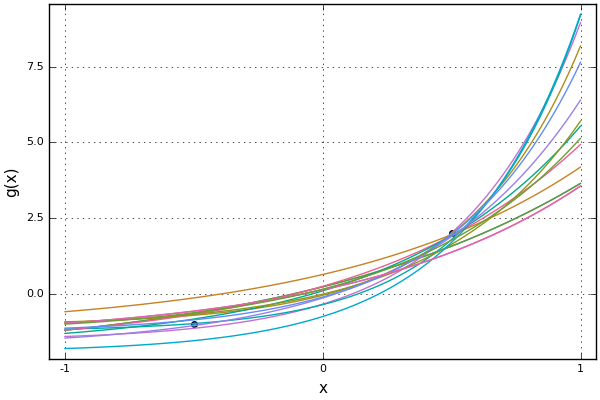

In [17]:
scatter(x,y)
for i = 1:15
    θ = chain[i,:]
    plot!(x -> g(x,θ), -1, 1)
end
plot!(xlabel = "x", ylabel = "g(x)", legend = false)

As shown, the models from the posterior distribution match the data more closely. We can sample the distribution a bit more and scatter the points in parameter-space.

In [18]:
nsamps = 1000;
chain = rto_mcmc(p,nsamps);

Optimizing for MAP... FTOL_REACHED.
Sampling... done.
Metropolizing... done.



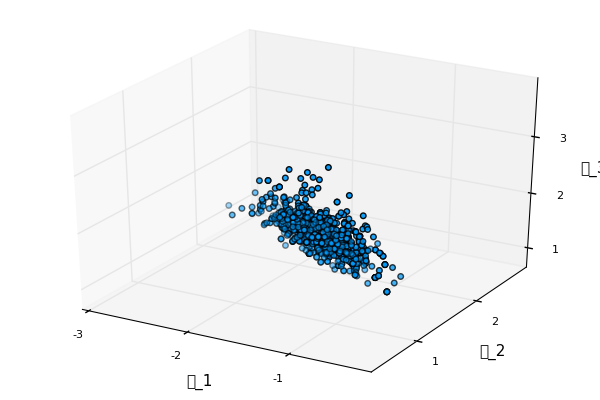

In [19]:
Plots.scatter(chain[:,1],chain[:,2],chain[:,3], xlabel = "θ_1", ylabel = "θ_2", zlabel = "θ_3",legend=false)

Here, we see an interesting 3D structure in the samples.

### (Optional) Using Mamba.jl
We can use `Mamba` to analyze the samples and to plot pair-wise marginal densities. 

In [26]:
#Pkg.add("Mamba") # Large package takes a long time to add
using Mamba

We need to define a `Mamba` chain and give it our matrix of samples.

In [21]:
sim = Chains(nsamps,3,names=[string("θ_",i) for i = 1:3])
sim[:,:,1] = chain;

It provides a few summary statistics and additional plotting commands.

In [22]:
describe(sim)

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

Empirical Posterior Estimates:
       Mean        SD       Naive SE      MCSE        ESS   
θ_1 -1.3160727 0.39644463 0.012536680 0.0131378284 910.57957
θ_2  1.2898335 0.41625100 0.013163012 0.0148390622 786.86037
θ_3  1.9096002 0.49275703 0.015582345 0.0160791736 939.15702

Quantiles:
        2.5%       25.0%      50.0%      75.0%      97.5%   
θ_1 -2.21113752 -1.5457606 -1.3005457 -1.0509942 -0.55766567
θ_2  0.61878601  0.9861015  1.2586059  1.5340074  2.28941198
θ_3  1.07896344  1.5517070  1.8589660  2.2007377  3.02222935



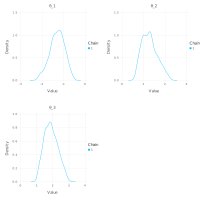

In [23]:
plt = Mamba.plot(sim[1:2:end,1:3,1],[:density],legend=true);
draw(plt, nrow=2,ncol=2)

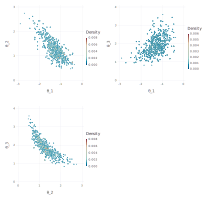

In [24]:
plt = Mamba.plot(sim[1:2:end,1:3,1],[:contour],legend=true);
draw(plt, nrow=2,ncol=2)